Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,9.6%
Cumulative returns,295.2%
Annual volatility,18.2%
Sharpe ratio,0.60
Calmar ratio,0.17
Stability,0.78
Max drawdown,-58.2%


/home/gitpod/anaconda3/envs/zip35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.17,2007-10-31,2009-03-09,2013-03-22,1408
1,12.98,2015-07-16,2015-08-25,2016-03-11,172
2,11.09,2004-03-05,2004-08-06,2004-10-06,154
3,10.16,2007-07-19,2007-08-16,2007-10-29,73
4,10.00,2003-01-06,2003-03-11,2003-03-21,55


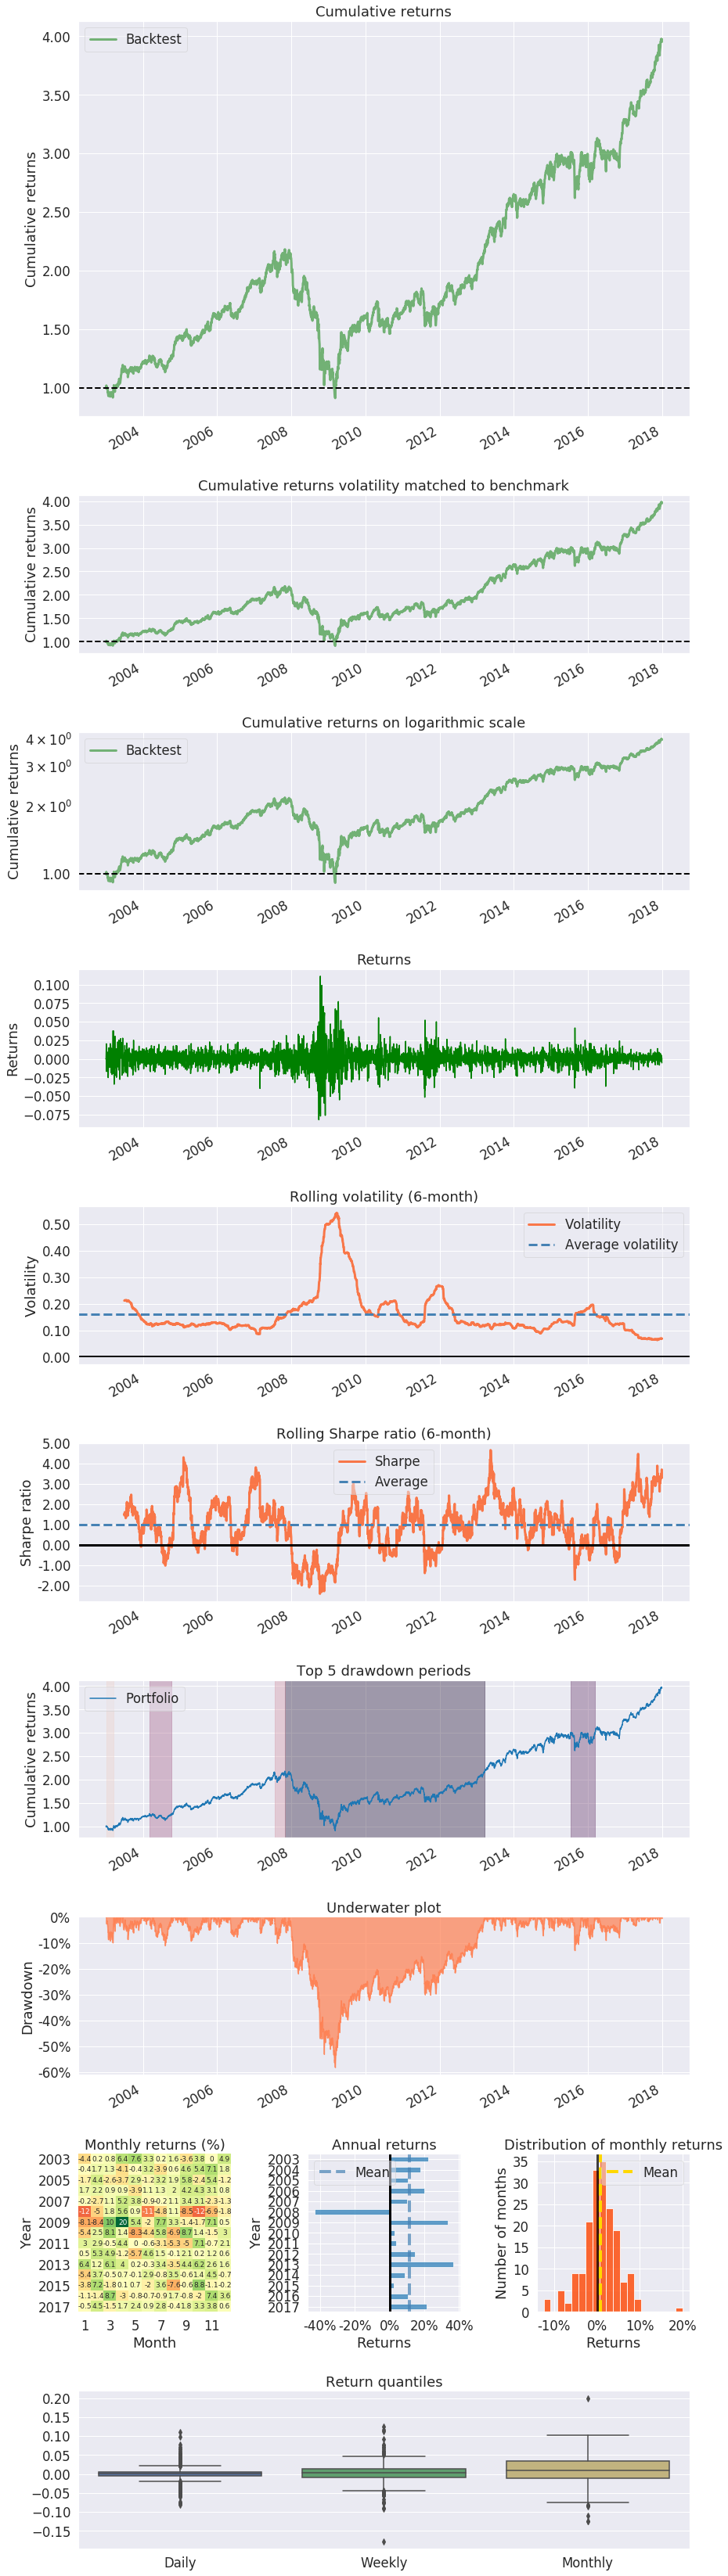

In [5]:
# This ensures that our graphs will be shown properly in the notebook.
#%matplotlib inline

# Import a few libraries we need
from zipline import run_algorithm

from zipline.api import order_target_percent, symbol,schedule_function,date_rules,time_rules
from datetime import datetime
import pytz
import pyfolio as pf

def initialize(context):
    # Which stock to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    context.universe=[symbol(s) for s in dji]
    context.history_window = 20
    context.stocks_to_hold = 10
    schedule_function(handle_data, date_rules.month_start(),time_rules.market_close())

def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf

def handle_data(context, data):
    # Get history for all the stocks.
    hist = data.history(context.universe, "close", context.history_window, "1d")

    # This creates a table of percent returns, in order.
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # Make buy list of the top N stocks
    buy_list = perf_table[:context.stocks_to_hold]

    # The rest will not be held.
    the_rest = perf_table[context.stocks_to_hold:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest.
    for stock, perf in the_rest.iteritems():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)

def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)


# Set start and end date
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2017, 12, 31, tzinfo=pytz.UTC)

# Fire off the backtest
result = run_algorithm(start=start, end=end,
                                initialize=initialize,
                                analyze=analyze,
                                capital_base=10000,
                                data_frequency = 'daily', bundle='quandl' )



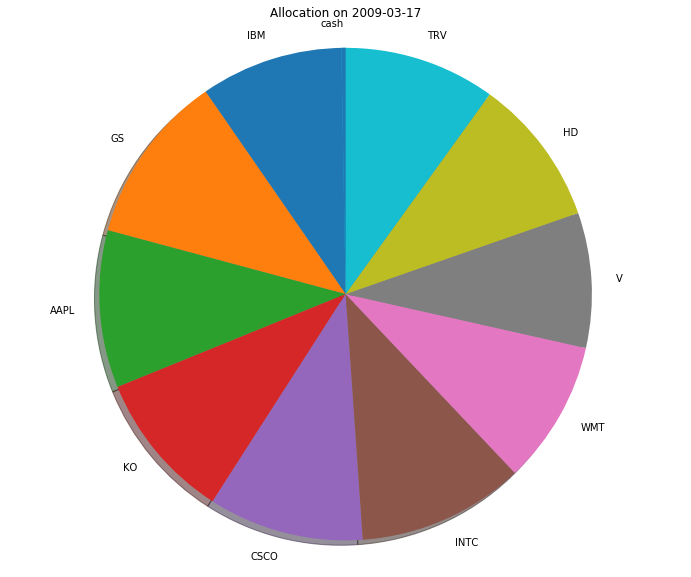

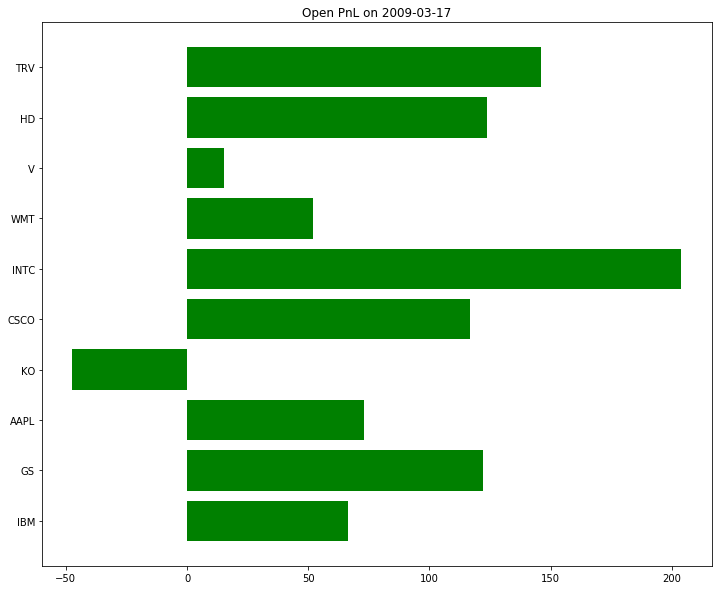

In [6]:
"""
This code need to be executed in a new notebook cell after a zipline result 
that has been already outputed
"""
# Import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Select day to view
day = '2009-03-17'

# Get portfolio value and positions for this day
port_value = result.loc[day,'portfolio_value']
day_positions = result.loc[day,'positions']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])

# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])

# Add cash position
df.loc['cash', ['value','pnl']] = [(port_value - df['value'].sum()), 0]

# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh( pnl_df.index, pnl_df['pnl'], align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()